In [15]:
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
tf.set_random_seed(0)

In [41]:
import math

In [2]:
mnist = read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [3]:
X = tf.placeholder(tf.float32, [None, 28, 28, 1])

In [4]:
Y_ = tf.placeholder(tf.float32, [None, 10])

# Standard nerural net setup

In [5]:
# W1 = tf.Variable(tf.truncated_normal([28*28, 500], stddev=0.1))
# B1 = tf.Variable(tf.ones([500])/10)

# W2 = tf.Variable(tf.truncated_normal([500, 500], stddev=0.1))
# B2 = tf.Variable(tf.ones([500])/10)

# W3 = tf.Variable(tf.truncated_normal([500, 500], stddev=0.1))
# B3 = tf.Variable(tf.ones([500])/10)

# W4 = tf.Variable(tf.truncated_normal([500, 500], stddev=0.1))
# B4 = tf.Variable(tf.ones([500])/10)

# W5 = tf.Variable(tf.truncated_normal([500, 10], stddev=0.1))
# B5 = tf.Variable(tf.ones([10])/10)

In [6]:
# XX = tf.reshape(X, [-1, 784])

In [7]:
# Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1)
# Y2 = tf.nn.relu(tf.matmul(Y1, W2) + B2)
# Y3 = tf.nn.relu(tf.matmul(Y2, W3) + B3)
# Y4 = tf.nn.relu(tf.matmul(Y3, W4) + B4)
# Ylogits = tf.matmul(Y4, W5) + B5
# Y  = tf.nn.softmax(Ylogits)

# CNN setup

In [29]:
W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 6], stddev=0.1))
B1 = tf.Variable(tf.ones([6])/10)

W2 = tf.Variable(tf.truncated_normal([4, 4, 6, 12], stddev=0.1))
B2 = tf.Variable(tf.ones([12])/10)

W3 = tf.Variable(tf.truncated_normal([4, 4, 12, 24], stddev=0.1))
B3 = tf.Variable(tf.ones([24])/10)

W4 = tf.Variable(tf.truncated_normal([7*7*24, 200], stddev=0.1))
B4 = tf.Variable(tf.ones([200])/10)

W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)

In [34]:
pkeep = tf.placeholder(tf.float32)

stride = 1  # output is still 28x28
Ycnv1 = tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME')
Y1 = tf.nn.relu(Ycnv1 + B1)
Y1d = tf.nn.dropout(Y1, pkeep)

stride2 = 2  # output is now 14x14
Ycnv2 = tf.nn.conv2d(Y1d, W2, strides=[1, stride2, stride2, 1], padding='SAME')
Y2 = tf.nn.relu(Ycnv2 + B2)
Y2d = tf.nn.dropout(Y2, pkeep)

stride3 = 2  # output is now 14x14
Ycnv3 = tf.nn.conv2d(Y2d, W3, strides=[1, stride3, stride3, 1], padding='SAME')
Y3 = tf.nn.relu(Ycnv3 + B3)
Y3d = tf.nn.dropout(Y3, pkeep)

XXX = tf.reshape(Y3d, [-1, 7*7*24])

Y4 = tf.nn.relu(tf.matmul(XXX, W4) + B4)
Y4d = tf.nn.dropout(Y4, pkeep)

Ylogits = tf.matmul(Y4d, W5) + B5
Y  = tf.nn.softmax(Ylogits)

# Cost and training

In [21]:
# cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y)) * 1000.0 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits( logits=Ylogits,labels= Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

In [22]:
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [38]:
lrate = tf.placeholder(tf.float32)
train_step = tf.train.AdamOptimizer(lrate).minimize(cross_entropy)

In [50]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [55]:
lrmin = 0.0001
lrmax = 0.005

def training_step(i, update_test_data, update_train_data):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)

    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y, pkeep:1.0})
        print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c))
        train_score_log.append((i,a))
    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels, pkeep:1.0})
        print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))
        test_score_log.append( (i,a) )
    
    # learning rate decay
    lr = lrmin+(lrmax-lrmin)*math.exp(-i/2000)
        
    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, pkeep:0.75, lrate:lr})

In [ ]:
train_score_log = []
test_score_log = []
for i in range(4000+1): training_step(i, i % 50 == 0, i % 10 == 0)

0: accuracy:1.0 loss: 0.173621
0: ********* epoch 1 ********* test accuracy:0.9901 test loss: 3.96691
10: accuracy:1.0 loss: 0.119568
20: accuracy:0.97 loss: 5.3204
30: accuracy:0.98 loss: 3.26325
40: accuracy:0.96 loss: 12.7665
50: accuracy:0.94 loss: 15.5917
50: ********* epoch 1 ********* test accuracy:0.9697 test loss: 11.1539
60: accuracy:0.98 loss: 6.64945
70: accuracy:0.97 loss: 9.02603
80: accuracy:0.98 loss: 6.25045
90: accuracy:0.98 loss: 4.71541
100: accuracy:0.96 loss: 16.5168
100: ********* epoch 1 ********* test accuracy:0.9678 test loss: 10.4405
110: accuracy:0.99 loss: 13.0791
120: accuracy:0.97 loss: 5.09352
130: accuracy:0.97 loss: 7.03501
140: accuracy:0.97 loss: 19.0122
150: accuracy:0.98 loss: 7.14376
150: ********* epoch 1 ********* test accuracy:0.9828 test loss: 6.35217
160: accuracy:0.97 loss: 8.31121
170: accuracy:1.0 loss: 0.943951
180: accuracy:0.99 loss: 3.1721
190: accuracy:0.99 loss: 3.33059
200: accuracy:0.95 loss: 14.1117
200: ********* epoch 1 ********

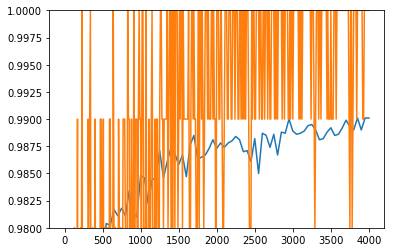

In [56]:
import matplotlib.pyplot as plt

plt.plot(list(zip(*test_score_log))[0],list(zip(*test_score_log))[1])
plt.plot(list(zip(*train_score_log))[0],list(zip(*train_score_log))[1])
plt.ylim(0.98,1)
plt.show()

In [53]:
sorted(list(zip(*test_score_log))[1])[-1]

0.99010003